# CHECKEN VOOR INLEVERING

- Is context uitgebreid genoeg?
- Zijn de aannames compleet?
- Worden alle aannames verdedigd?
- "De stroom aan nieuwe COVID-patiënten is redelijk consistent; er is geen sprake van vlagen in bepaalde seizoenen." -> klopt dit?
- Tijdspanne inderdaad 3 maanden? En hoe groot is elke tijdstap in de simulatie?
-

# Setup

## Imports

In [166]:
# Imports
import pandas as pd
import itertools
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

## Configs

Hier kunnen we bepalen welke verschillende configuraties we willen testen, en genereren op basis daarvan alle configuratie-mogelijkheden.
We willen testen met een totale bedcapaciteit van 20-40 bedden (wat als indicatie gegeven werd door de opdrachtgever) en een totaal van 5 (alle) verschillende specialisaties. Het probleem dat hierdoor ontstaat, is dat er te veel mogelijke combinaties bestaan van verschillende bedconfiguraties (50,000+). Om dit probleem tegen te gaan, beperken we het aantal mogelijke combinaties door bedcapaciteit steeds met 5 te verhogen en het aantal bedden van minder belangrijke specialisaties minder vaak mogen voorkomen in de combinaties.

### Auto-generated Configs

In [167]:
# Genereer alle mogelijke verdelingen van bedtype die optellen tot de bedcapaciteit
def generate_configurations(bed_capacity_range, num_specializations, max_occurrence):
    configurations = []
    for capacity in bed_capacity_range:
        for beds_distribution in itertools.combinations_with_replacement(range(capacity + 1), num_specializations):
            if sum(beds_distribution) <= capacity:
                config = {}
                valid_config = True

                for i, beds in enumerate(beds_distribution, start=1):
                    bed_type = f'Specialisatie_{i}'
                    max_percentage = max_occurrence.get(bed_type, 1)  # Standaard 100% als niet gespecificeerd
                    if beds / capacity <= max_percentage:
                        config[bed_type] = beds
                    else:
                        valid_config = False
                        break

                if valid_config:
                    generic_beds = capacity - sum(beds_distribution)
                    config['Generiek'] = generic_beds
                    configurations.append(config)

    return configurations

# Parameters instellen
bed_capacity_range = range(20, 41, 5)  # AANTAL BEDDEN in stappen van 5
num_specializations = 4               # AANTAL TYPE BEDDEN (EXCL. GENERIEK)
max_occurrence = {'Generiek': 1, 'Specialisatie_1': 0.6, 'Specialisatie_2': 0.15, 'Specialisatie_3': 0.15, 'Specialisatie_4': 0.15}  # Maximale percentages

configurations = generate_configurations(bed_capacity_range, num_specializations, max_occurrence)

# Toon aantal configuraties
len(configurations)

476

### Manual Configs

Voor het geval je een specifieke configuratie wilt testen, kan dat hier.

In [168]:
manual_configs = False # False voor auto-generated configs, True voor zelf-gespecificeerde configs

if manual_configs:
    configurations = [
        {'Generiek': 20, 'Specialisatie_1': 0, 'Specialisatie_2': 0, 'Specialisatie_3': 0, 'Specialisatie_4': 0},
        {'Generiek': 0, 'Specialisatie_1': 5, 'Specialisatie_2': 5, 'Specialisatie_3': 5, 'Specialisatie_4': 5},
        {'Generiek': 20, 'Specialisatie_1': 5, 'Specialisatie_2': 5, 'Specialisatie_3': 5, 'Specialisatie_4': 5},
        {'Generiek': 40, 'Specialisatie_1': 0, 'Specialisatie_2': 0, 'Specialisatie_3': 0, 'Specialisatie_4': 0},
        {'Generiek': 0, 'Specialisatie_1': 10, 'Specialisatie_2': 10, 'Specialisatie_3': 10, 'Specialisatie_4': 10},
    ]

## Prepareren Data

In [169]:
csv_file_path = 'Analysis.csv'

if os.path.exists(csv_file_path):
    os.remove(csv_file_path)

## Runnen Simulaties

In het geval de echte simulatie (nog) niet werkt, is hier code voor een dummy-simulatie die semi-random data genereert op basis van de gegeven simulatie.

In [170]:
# Dummy-simulatie
def run_simulation(config_id, generic_beds, spec1_beds, spec2_beds, spec3_beds, spec4_beds):
    # Basiscapaciteit en bezettingsgraad
    bed_capacity = generic_beds + spec1_beds + spec2_beds + spec3_beds + spec4_beds
    occupancy_rate = round(random.uniform(0.5, 1) * 100)  # Afgerond tot 2 decimalen

    # Afhankelijk van de capaciteit en bezettingsgraad, bereken andere waarden
    afwijzingen = int((100 - occupancy_rate) * bed_capacity * random.uniform(0.1, 0.5))
    geplande_patienten = int((occupancy_rate * bed_capacity * random.uniform(0.0, 0.7)) / 100)
    ongeplande_patienten = bed_capacity - geplande_patienten
    herplande_patienten = int(geplande_patienten * random.uniform(0, 0.2))

    # Gemiddelde verblijfsduur en maximale bezettingsgraad
    gemiddelde_verblijfsduur = round(random.uniform(1, 10), 1)  # Afgerond tot 1 decimaal
    max_bezettingsgraad = round(random.uniform(occupancy_rate, 100))  # Afgerond tot 2 decimalen

    resultaten = {
        'Configuratie_ID': config_id,
        'Bedcapaciteit': bed_capacity,
        'Aantal_Generiek_Bed': generic_beds,
        'Aantal_S1_Bed': spec1_beds,
        'Aantal_S2_Bed': spec2_beds,
        'Aantal_S3_Bed': spec3_beds,
        'Aantal_S4_Bed': spec4_beds,
        'Bezettingsgraad': f"{occupancy_rate}%",  # Als percentage
        'Aantal_Afwijzingen': afwijzingen,
        'Aantal_Geplande_Patienten': geplande_patienten,
        'Aantal_Ongeplande_Patienten': ongeplande_patienten,
        'Aantal_Herplande_Patienten': herplande_patienten,
        'Gemiddelde_Verblijfsduur': gemiddelde_verblijfsduur,
        'Max_Bezettingsgraad': f"{max_bezettingsgraad}%",  # Als percentage
        'Simulatie_Stappen': 10000
    }

    return resultaten

def save_to_csv(resultaten, csv_filename='Analysis.csv'):
    columns = ["Configuratie_ID", "Bedcapaciteit", "Aantal_Generiek_Bed", "Aantal_S1_Bed",
           "Aantal_S2_Bed", "Aantal_S3_Bed", "Aantal_S4_Bed", "Bezettingsgraad",
           "Aantal_Afwijzingen", "Aantal_Geplande_Patienten", "Aantal_Ongeplande_Patienten",
           "Aantal_Herplande_Patienten", "Gemiddelde_Verblijfsduur", "Max_Bezettingsgraad",
           "Simulatie_Stappen"]

    df = pd.DataFrame([resultaten], columns=columns)

    if os.path.exists(csv_file_path):
        df.to_csv(csv_filename, mode='a', header=pd.read_csv(csv_filename).empty, index=False)
    else:
        df.to_csv(csv_filename, mode='w', header=True, index=False)

In [171]:
i = 0
for config in configurations:
    config_name = f"Config_{i}"
    i += 1
    save_to_csv(run_simulation(config_name, config["Generiek"], config["Specialisatie_1"], config["Specialisatie_2"], config["Specialisatie_3"], config["Specialisatie_4"]))

csv_file_path = 'Analysis.csv'

df = pd.read_csv("Analysis.csv")
df.head()

,Configuratie_ID,Bedcapaciteit,Aantal_Generiek_Bed,Aantal_S1_Bed,Aantal_S2_Bed,Aantal_S3_Bed,Aantal_S4_Bed,Bezettingsgraad,Aantal_Afwijzingen,Aantal_Geplande_Patienten,Aantal_Ongeplande_Patienten,Aantal_Herplande_Patienten,Gemiddelde_Verblijfsduur,Max_Bezettingsgraad,Simulatie_Stappen
0,Config_0,20,20,0,0,0,0,80%,42,2,18,0,8.1,94%,10000
1,Config_1,20,19,0,0,0,1,59%,269,1,19,0,4.0,78%,10000
2,Config_2,20,18,0,0,0,2,59%,409,2,18,0,1.3,73%,10000
3,Config_3,20,17,0,0,0,3,66%,199,4,16,0,3.8,75%,10000
4,Config_4,20,18,0,0,1,1,69%,104,6,14,0,5.2,99%,10000


## Functies

Hier worden alle benodigde functies gemaakt voor het visualiseren van data uit onze simulatie. Sla voor de resultaten rustig deze sectie over.

### Barchart

In [185]:
def create_barchart(data, x_col, y_col, title="", xlabel="", ylabel="", hue=None, color=None, figsize=(15, 9)):
    plt.figure(figsize=figsize)

    if hue is None:
        if color is None:
            color = 'blue'
        sns.barplot(x=x_col, y=y_col, data=data, color=color)
    else:
        if color is None:
            color = sns.color_palette("tab10")
        sns.barplot(x=x_col, y=y_col, hue=hue, data=data, palette=color)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.legend(title=hue)
    plt.show()

### Lijngrafiek

### Boxplot

### Scatterplot

### Heatmap

### Test

C:\Users\Boris\AppData\Local\Temp\ipykernel_31172\3886035601.py:11: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(x=x_col, y=y_col, hue=hue, data=data, palette=color)


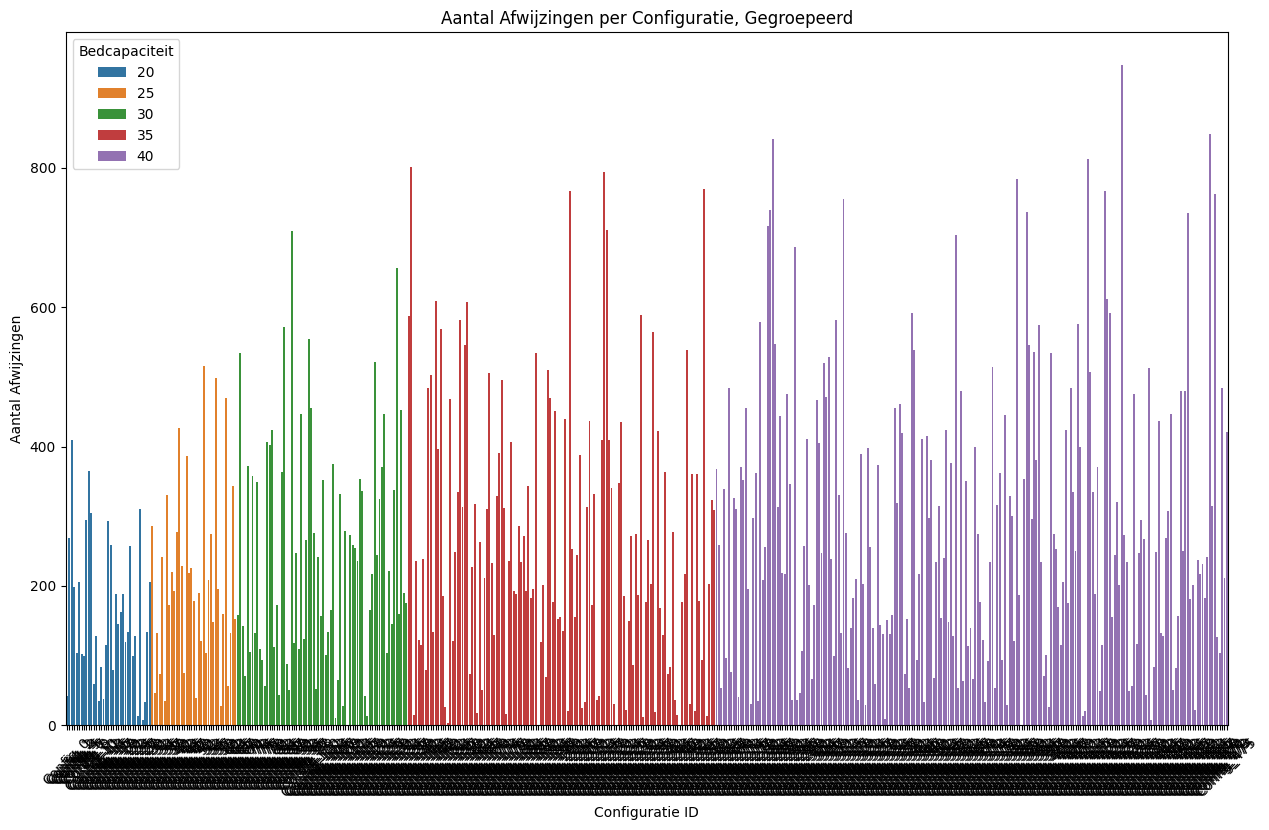

In [188]:
create_barchart(df, x_col='Configuratie_ID', y_col='Aantal_Afwijzingen',
                hue='Bedcapaciteit',
                title='Aantal Afwijzingen per Configuratie, Gegroepeerd',
                xlabel='Configuratie ID', ylabel='Aantal Afwijzingen')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


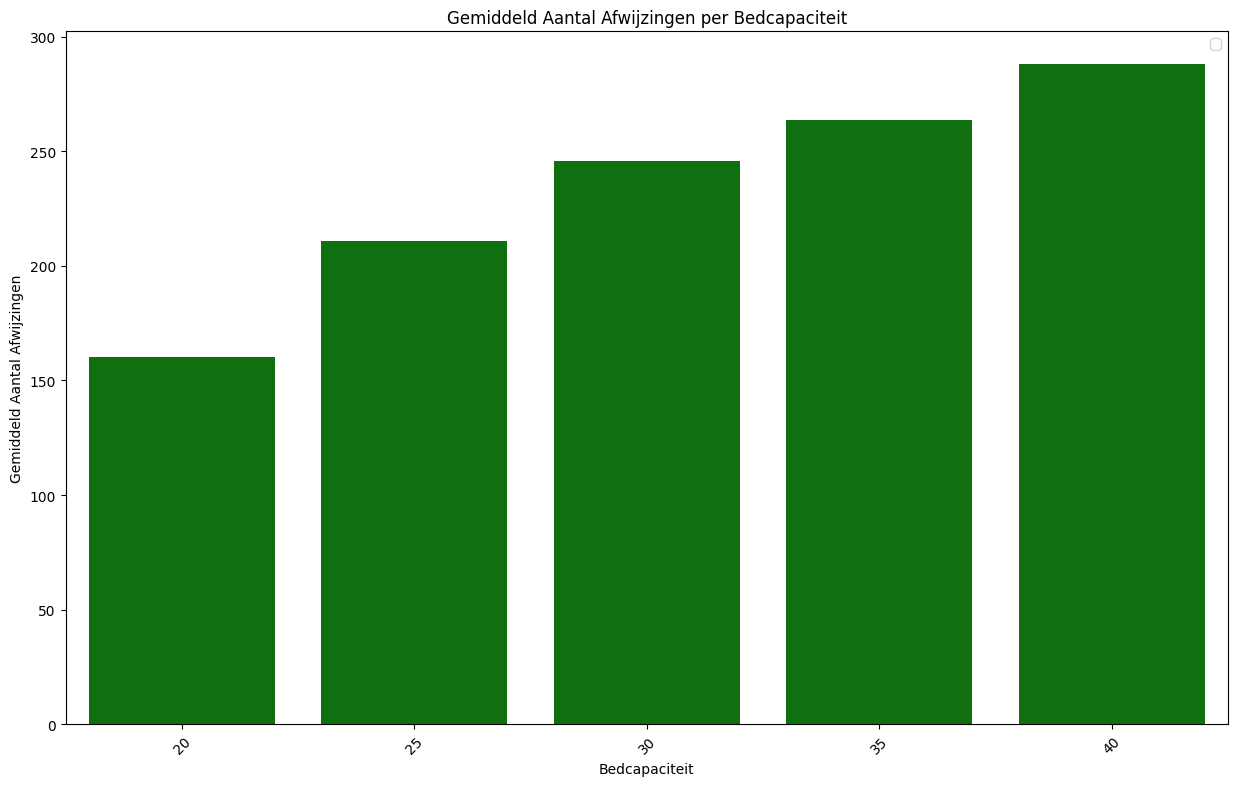

In [187]:
df['Bedcapaciteit'] = df['Bedcapaciteit'].astype(str)
aggregated_data = df.groupby('Bedcapaciteit')['Aantal_Afwijzingen'].mean().reset_index()

create_barchart(aggregated_data, x_col='Bedcapaciteit', y_col='Aantal_Afwijzingen',
                title='Gemiddeld Aantal Afwijzingen per Bedcapaciteit',
                xlabel='Bedcapaciteit', ylabel='Gemiddeld Aantal Afwijzingen',
                color='green')

# Inleiding

In deze Jupyter Notebook zullen we een diepgaande data-analyse uitvoeren op de resultaten verkregen uit onze ziekenhuis-simulatie. Het doel is om hieruit inzicht te krijgen over de optimale beddenconfiguratie om de bezettingsgraad van bedden zo hoog mogelijk te houden, maar ook het aantal afwijzingen te minimaliseren. Op basis van de resultaten geven wij een advies over de ideale beddenconfiguratie.

## Context

Ziekenhuizen beschikken over zowel aandoening-specifieke als generieke IC-bedden. Zo kan er een ruimte zijn met bedden die gereserveerd is voor patiënten met COVID-19, en een ruimte met generieke (alle overige) aandoeningen.
Het voordeel van generieke bedden is dat elk type patiënt hier in kan liggen; de kans op afwijzing van een nieuwe patiënt wordt daardoor kleiner, omdat er enkel geen plek meer zou zijn als elk bed in het ziekenhuis bezet is. Het nadeel is echter dat een patiënt met COVID niet in de ruimte bij niet-COVID patiënten mag liggen wegens kans op besmetting.
Daarom is aan ons de taak de optimale beddenconfiguratie te bepalen, zodat bedden goed benut worden zonder veel mensen af te moeten wijzen.

## Aannames

- Er worden niet met bedden geschoven tussen verschillende afdelingen.
- De stroom aan nieuwe COVID-patiënten is redelijk consistent; er is geen sprake van vlagen in bepaalde seizoenen.
- Het aantal beschikbare bedden staat vanaf het begin van de simulatie vast.
- Zodra een patiënt is ontslagen uit het ziekenhuis, komt zijn bed onmiddellijk vrij.
- Ongeplande patiënten krijgen voorrang op geplande patiënten.
- Mensen met infectie komen in een daarvoor-bestemde afdeling terecht.
- Er wordt geen onderscheid gemaakt tussen COVID-patiënten en patiënten met andere infecties

## Modelleerkeuzes

### Finite State Machine

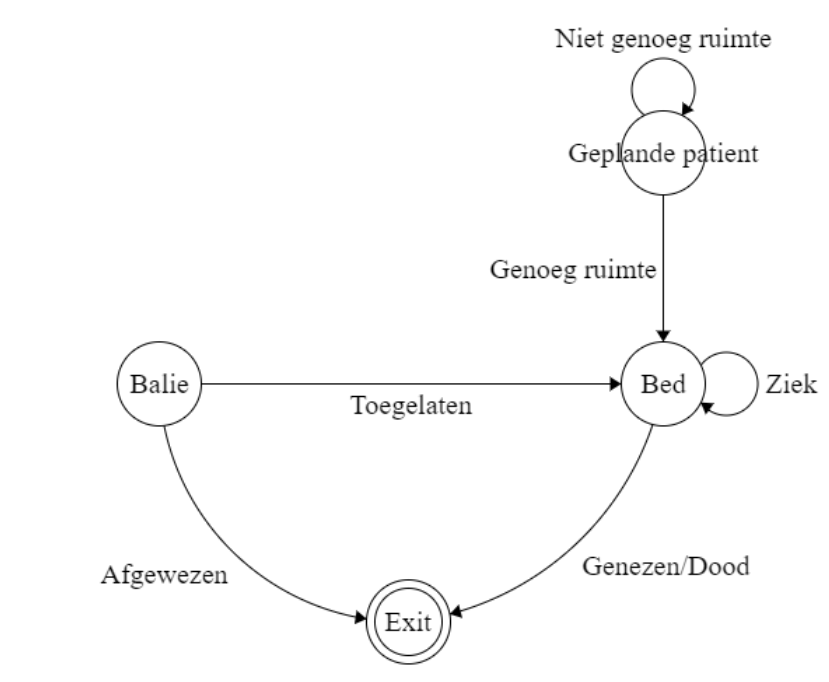

In [174]:
Image(filename='FSM.png')

Wij kiezen ervoor om in ons model gebruik te maken van een FSM, aangezien er duidelijk definieerbare discrete staten zijn waarin agents zich verkeren. Het aantal states is dan ook vrij beperkt en goed te doen. Zie hierboven hoe onze Finite State Machine eruitziet.

### Tijdspanne

We zullen een periode van 3 maanden simuleren om zo een goed beeld te krijgen van de bezettingsgraad en het aantal afwijzingen over de tijd heen, maar de simulatie snel genoeg draait om hem meerdere malen uit te kunnen voeren.

### Aanpasbare parameters / Te testen configuraties

Om met onze simulatie tot een volwaardige conclusie te komen, zijn er een verschillende parameters waar we mee willen experimenteren en analyse op uit willen voeren. Deze luiden als volgt:

- Bedconfiguratie (verdeling bedden over 5 verschillende afdelingen)
- Totale bedcapaciteit (20-40 bedden)